# Introduction

This lab illustrates the effect of varying threshold on self-training. The **breast_cancer** dataset is loaded, and labels are deleted such that only 50 out of 569 samples have labels. A **SelfTrainingClassifier** is fitted on this dataset, with varying thresholds.

# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Load Data

In [7]:
n_splits = 3

X, y = datasets.load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1
total_samples = y.shape[0]

The **breast_cancer** dataset is loaded and shuffled. We then copy the true labels to **y_true**, and remove all labels except for the first 50 samples from **y**. This will be used to simulate a semi-supervised learning scenario.

# Define Classifier

In [3]:
base_classifier = SVC(probability=True, gamma=0.001, random_state=42)

We define our base classifier as a Support Vector Machine (SVM) with a low gamma value of 0.001.

# Define Threshold Values

In [6]:
x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)
x_values

array([0.4    , 0.45   , 0.5    , 0.55   , 0.6    , 0.65   , 0.7    ,
       0.75   , 0.8    , 0.85   , 0.9    , 0.95   , 1.     , 0.99999])

We define an array of threshold values ranging from 0.4 to 1, with steps of 0.05. We then append a very high threshold value of 0.99999 to ensure that we include a threshold value that will not result in any self-labeled samples.

# Define Arrays for Results

In [8]:
scores = np.empty((x_values.shape[0], n_splits))
amount_labeled = np.empty((x_values.shape[0], n_splits))
amount_iterations = np.empty((x_values.shape[0], n_splits))

# Self-training with Varying Threshold

In [10]:
for i, threshold in enumerate(x_values):
    self_training_clf = SelfTrainingClassifier(base_classifier, threshold=threshold)

    skfolds = StratifiedKFold(n_splits=n_splits)
    for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        y_test_true = y_true[test_index]

        self_training_clf.fit(X_train, y_train)

        amount_labeled[i, fold] = (
            total_samples
            - np.unique(self_training_clf.labeled_iter_, return_counts=True)[1][0]
        )

        amount_iterations[i, fold] = np.max(self_training_clf.labeled_iter_)

        y_pred = self_training_clf.predict(X_test)
        scores[i, fold] = accuracy_score(y_test_true, y_pred)

We perform self-training with varying thresholds, using our base classifier and the **SelfTrainingClassifier** class from scikit-learn. We use stratified k-fold cross-validation to split our data into train and test sets. We then fit the self-training classifier on the training set, and calculate the accuracy of the classifier on the test set. We also store the amount of labeled samples and the iteration number for each fold.

# Visualize Results

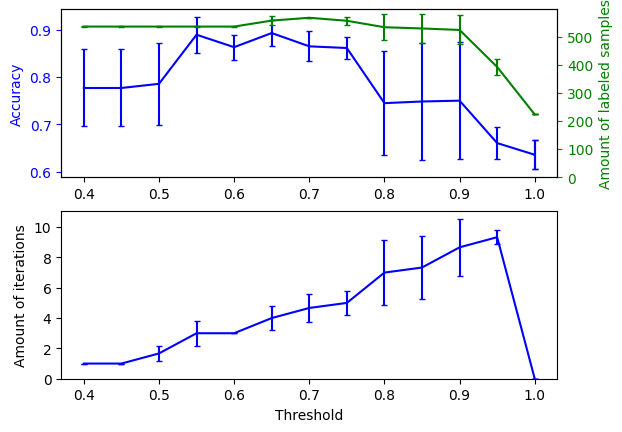

In [11]:
ax1 = plt.subplot(211)
ax1.errorbar(
    x_values, scores.mean(axis=1), yerr=scores.std(axis=1), capsize=2, color="b"
)
ax1.set_ylabel("Accuracy", color="b")
ax1.tick_params("y", colors="b")

ax2 = ax1.twinx()
ax2.errorbar(
    x_values,
    amount_labeled.mean(axis=1),
    yerr=amount_labeled.std(axis=1),
    capsize=2,
    color="g",
)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Amount of labeled samples", color="g")
ax2.tick_params("y", colors="g")

ax3 = plt.subplot(212, sharex=ax1)
ax3.errorbar(
    x_values,
    amount_iterations.mean(axis=1),
    yerr=amount_iterations.std(axis=1),
    capsize=2,
    color="b",
)
ax3.set_ylim(bottom=0)
ax3.set_ylabel("Amount of iterations")
ax3.set_xlabel("Threshold")

plt.show()

We plot the results of our experiment using Matplotlib. The upper graph shows the amount of labeled samples that the classifier has available by the end of fit, and the accuracy of the classifier. The lower graph shows the last iteration in which a sample was labeled.

# Summary

In this lab, we learned how to perform self-training with varying threshold values using scikit-learn. We saw that the optimal threshold value lies in between very low and very high thresholds, and that choosing an appropriate threshold value can result in significant improvements in accuracy.